In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Descriptors

import pathlib

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from matplotlib import rcParams
rcParams["font.size"] = 20

# Read Data

In [3]:
db_conf = pd.read_parquet("../db_conf.parquet")
db_conf.index = db_conf["db_idx"]
db_conf.drop(columns=["Unnamed: 0", "db_idx"], inplace=True)
db_conf["mol"] = db_conf["smiles"].apply(Chem.MolFromSmiles)
# db_conf.drop(columns=["CONF", "CONFCl", "CONFClBr", "CONFClBrI"], inplace=True)
db_conf = db_conf.reset_index(drop=True)

In [4]:
na_ind = db_conf[db_conf.iloc[:,4:-1].isna().all(axis=1)].index

In [5]:
db_conf = db_conf.drop(index=na_ind)
db_conf = db_conf.reset_index(drop=True)

# Labels Encoding

In [6]:
from sklearn import preprocessing

In [7]:
le = preprocessing.LabelEncoder()
le.fit(["nB", "B"])
db_conf["class_encoded"] = le.transform(db_conf["Experimental BCF class"])

In [8]:
db_conf["class_encoded"] = db_conf["class_encoded"].replace({1:0, 0:1})

In [9]:
db_conf

,smiles,Experimental logarithmic BCF,Experimental BCF class,FQD_2,FQD_3,FQD_4,FQD_5,FQD_6,FQD_7,FQD_8,FQD_9,mol,class_encoded
0,CNc1cccc(C)c1,0.849,nB,[6],None,None,None,[213],"[929, 939]","[4340, 5388]",[32107],<rdkit.Chem.rdchem.Mol object at 0x7fb189e8ac80>,0
1,CC(COc1ccc(Oc2ccccc2)cc1)Oc1ccccn1,3.140,B,"[6, 7]","[12, 13, 14]","[21, 39, 40, 41]","[81, 84, 134, 136]","[213, 214, 277, 395, 548]","[948, 953, 1578]","[4590, 5397, 5402]","[31844, 33001, 33006]",<rdkit.Chem.rdchem.Mol object at 0x7fb189e8aaa0>,1
2,CCCCCCCC/C=C\CCCCCCCCCCCCC,1.176,nB,[6],[12],[38],[132],[542],[2719],[14787],[123245],<rdkit.Chem.rdchem.Mol object at 0x7fb189e8ab60>,0
3,Clc1ccccc1Cl,2.500,nB,None,None,None,None,[213],[134076],[135441],None,<rdkit.Chem.rdchem.Mol object at 0x7fb189e8ab00>,0
4,Nc1cccc([N+](=O)[O-])c1,0.522,nB,None,None,None,None,[213],[939],[4360],[131914],<rdkit.Chem.rdchem.Mol object at 0x7fb189e8aa40>,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,CC1=C(C)S(=O)(=O)CCS1(=O)=O,0.633,nB,[6],None,None,None,"[133896, 133900]","[134043, 134044, 134066, 134068]","[135086, 135404, 135405]",[145115],<rdkit.Chem.rdchem.Mol object at 0x7fb189eaf220>,0
835,FC(F)(F)c1ccc(Cl)c(Cl)c1,3.176,B,[6],None,None,None,[213],"[929, 134076]","[134378, 134382, 135441]",[137748],<rdkit.Chem.rdchem.Mol object at 0x7fb189eaf280>,1
836,CN(C)[C@@H]1C(=O)C(C(=N)O)=C(O)[C@@]2(O)C(=O)C...,-0.222,nB,"[5, 6, 7]","[10, 12, 13]","[17, 20, 21, 34, 37, 38, 39, 41]","[54, 67, 68, 70, 71, 80, 81, 82, 83, 127, 131,...","[213, 224, 226, 228, 254, 258, 259, 260, 271, ...","[929, 948, 1092, 1094, 1099, 1104, 1119, 1129,...","[4341, 4957, 4959, 5378, 5407, 5809, 5841, 584...","[26263, 26273, 28867, 32083, 32170, 32193, 322...",<rdkit.Chem.rdchem.Mol object at 0x7fb189eaf2e0>,0
837,CC(C)N(C(=O)CCl)c1ccccc1,1.568,nB,"[5, 6]","[10, 11, 12]","[18, 35]","[69, 73, 128]","[213, 255, 262, 288, 386]","[939, 1121, 1626, 1677]","[5388, 7443]","[25503, 26283, 32992]",<rdkit.Chem.rdchem.Mol object at 0x7fb189eaf340>,0


# RDKit descriptors

In [10]:
descriptors_names = [ x[0] for x in Descriptors._descList ] #list of all RDKit Descriptors
calculator = MoleculeDescriptors.MolecularDescriptorCalculator( descriptors_names )
descriptors = []
maccs_keys = []
morgan_fp = []
for mol in db_conf["mol"]:
    descriptors.append(calculator.CalcDescriptors(mol))
    maccs_keys.append(pd.Series(np.asarray(MACCSkeys.GenMACCSKeys(mol))))
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 4, nBits=2048)
    fp_vect = np.zeros((1,))
    AllChem.DataStructs.ConvertToNumpyArray(fp, fp_vect)
    morgan_fp.append(pd.Series(fp_vect))
cols_rdkit = descriptors_names + [f"MACCS_key{x}" for x in range(len(maccs_keys[0]))] + [f"MorganFP_bit_{x}" for x in range(2048)]
cols = list(db_conf.columns) + cols_rdkit
dat3 = pd.concat([db_conf.reset_index(drop=True), pd.DataFrame(descriptors), pd.DataFrame(maccs_keys), pd.DataFrame(morgan_fp)], axis=1)
dat3.columns = cols


In [11]:
dat3

,smiles,Experimental logarithmic BCF,Experimental BCF class,FQD_2,FQD_3,FQD_4,FQD_5,FQD_6,FQD_7,FQD_8,...,MorganFP_bit_2038,MorganFP_bit_2039,MorganFP_bit_2040,MorganFP_bit_2041,MorganFP_bit_2042,MorganFP_bit_2043,MorganFP_bit_2044,MorganFP_bit_2045,MorganFP_bit_2046,MorganFP_bit_2047
0,CNc1cccc(C)c1,0.849,nB,[6],None,None,None,[213],"[929, 939]","[4340, 5388]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CC(COc1ccc(Oc2ccccc2)cc1)Oc1ccccn1,3.140,B,"[6, 7]","[12, 13, 14]","[21, 39, 40, 41]","[81, 84, 134, 136]","[213, 214, 277, 395, 548]","[948, 953, 1578]","[4590, 5397, 5402]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CCCCCCCC/C=C\CCCCCCCCCCCCC,1.176,nB,[6],[12],[38],[132],[542],[2719],[14787],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Clc1ccccc1Cl,2.500,nB,None,None,None,None,[213],[134076],[135441],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Nc1cccc([N+](=O)[O-])c1,0.522,nB,None,None,None,None,[213],[939],[4360],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,CC1=C(C)S(=O)(=O)CCS1(=O)=O,0.633,nB,[6],None,None,None,"[133896, 133900]","[134043, 134044, 134066, 134068]","[135086, 135404, 135405]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
835,FC(F)(F)c1ccc(Cl)c(Cl)c1,3.176,B,[6],None,None,None,[213],"[929, 134076]","[134378, 134382, 135441]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
836,CN(C)[C@@H]1C(=O)C(C(=N)O)=C(O)[C@@]2(O)C(=O)C...,-0.222,nB,"[5, 6, 7]","[10, 12, 13]","[17, 20, 21, 34, 37, 38, 39, 41]","[54, 67, 68, 70, 71, 80, 81, 82, 83, 127, 131,...","[213, 224, 226, 228, 254, 258, 259, 260, 271, ...","[929, 948, 1092, 1094, 1099, 1104, 1119, 1129,...","[4341, 4957, 4959, 5378, 5407, 5809, 5841, 584...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
837,CC(C)N(C(=O)CCl)c1ccccc1,1.568,nB,"[5, 6]","[10, 11, 12]","[18, 35]","[69, 73, 128]","[213, 255, 262, 288, 386]","[939, 1121, 1626, 1677]","[5388, 7443]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
bin_cols = [f"MACCS_key{x}" for x in range(len(maccs_keys[0]))] + [f"MorganFP_bit_{x}" for x in range(2048)]

In [14]:
x = dat3.iloc[:, 13:]
y = dat3["class_encoded"]

# Fill data

In [15]:
x = x.fillna(0)

# OOB dataset creation

In [16]:
oob_idx = np.loadtxt("oob_idx").astype(int)
train_idx = np.loadtxt("train_idx").astype(int)

In [17]:
res_x, res_y = x.loc[list(train_idx.astype(int))], y.loc[list(train_idx.astype(int))]

In [18]:
oob_x, oob_y = x.loc[list(oob_idx)], y.loc[list(oob_idx)]

In [19]:
x, y = res_x, res_y

In [20]:
y.value_counts()

0    409
1    117
Name: class_encoded, dtype: int64

# Hyperparameters tuning with GridSearchCV

# Pipeline

# Pipeline creation

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler

In [28]:
from sklearn.metrics import f1_score, balanced_accuracy_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

In [29]:
from sklearn.model_selection import StratifiedKFold

def my_score(model, n_folds, scoring_callable, X, Y):
    scores = []
    cv = StratifiedKFold(n_folds)
    oversampler = RandomOverSampler(random_state=1)
    preprocessor = ColumnTransformer(
        [("prep", Pipeline([
            ("scaler", StandardScaler()),
        ]),
                                     descriptors_names)], remainder="passthrough")

    for train_index, validation_index in cv.split(X, Y):
        x, y = X.iloc[train_index], Y.iloc[train_index]
        xx, yy = oversampler.fit_resample(x, y)
        xx = preprocessor.fit_transform(xx)
        model.fit(xx, yy)
        x_val = X.iloc[validation_index]
        x_val = preprocessor.transform(x_val)
        score = scoring_callable(Y.iloc[validation_index], model.predict(x_val))
        scores.append(score)
    
    return np.array(scores).mean()

In [30]:
""""lgb__max_depth": range(3, 12),
"lgb__n_estimators": [200, 350, 500, 1000],
"lgb__learning_rate": [0.01, 0.05, 0.1, 0.15],
"lgb__reg_alpha": range(0, 15),
"lgb__reg_lambda": range(0,15)"""

import itertools
params = list(itertools.product(range(3, 12),
        [200, 350, 500, 1000],
        [0.01, 0.05, 0.1, 0.15],
        range(0, 15),
        range(0,15)))
result = pd.DataFrame(params)
result.columns = "max_depth,n_estimators,learning_rate,reg_alpha,reg_lambda".split(",")


In [31]:
scores = []
for max_depth, n_estimators, learning_rate, reg_alpha, reg_lambda in params:
    model = xgb.XGBClassifier(
        max_depth=max_depth,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=1
        )
    scores.append(my_score(model, 5, f1_score, x, y))

result["f_score"] = scores

KeyboardInterrupt: 

In [31]:
result.to_csv("hyperparams_rdkit_results.csv")
# result = pd.read_csv("hyperparams_rdkit_results.csv")

In [34]:
result[result["f_score"]==result["f_score"].max()]

,Unnamed: 0,max_depth,n_estimators,learning_rate,reg_alpha,reg_lambda,f_score
4504,4504,4,350,0.01,0,4,0.777004


# OOB test

## Scale and apply PCA to training dataset

In [35]:
oversampler = RandomOverSampler(random_state=1)
preprocessor = ColumnTransformer(
        [("prep", Pipeline([
            ("scaler", StandardScaler()),
        ]),
                                     descriptors_names)], remainder="passthrough")

oob_scores = []
bal_acc_scores = []
preds = []
xx, yy = oversampler.fit_resample(x, y)
xx = preprocessor.fit_transform(xx)
for i in range(5):
    model = xgb.XGBClassifier(
        max_depth=4,
        n_estimators=350,
        learning_rate=0.01,
        reg_alpha=0,
        reg_lambda=4,
        random_state=60+i
        )
    model.fit(xx, yy)
    x_val = oob_x
    x_val = preprocessor.transform(x_val)
    pred = model.predict(x_val)
    score = f1_score(oob_y, pred)
    preds.append(pred)
    oob_scores.append(score)
    score = balanced_accuracy_score(oob_y, pred)
    bal_acc_scores.append(score)
    

In [36]:
oob_scores

[0.759493670886076,
 0.759493670886076,
 0.759493670886076,
 0.759493670886076,
 0.759493670886076]

In [39]:
bal_acc_scores

[0.8753563791874555,
 0.8753563791874555,
 0.8753563791874555,
 0.8753563791874555,
 0.8753563791874555]

## LGBMC
With tuned hyperparameters

In [40]:
from sklearn.metrics import confusion_matrix
conf_mats = [confusion_matrix(le.inverse_transform(oob_y), le.inverse_transform(pred)) for pred in preds]
conf_mats

[array([[215,  29],
        [  9,  60]]),
 array([[215,  29],
        [  9,  60]]),
 array([[215,  29],
        [  9,  60]]),
 array([[215,  29],
        [  9,  60]]),
 array([[215,  29],
        [  9,  60]])]

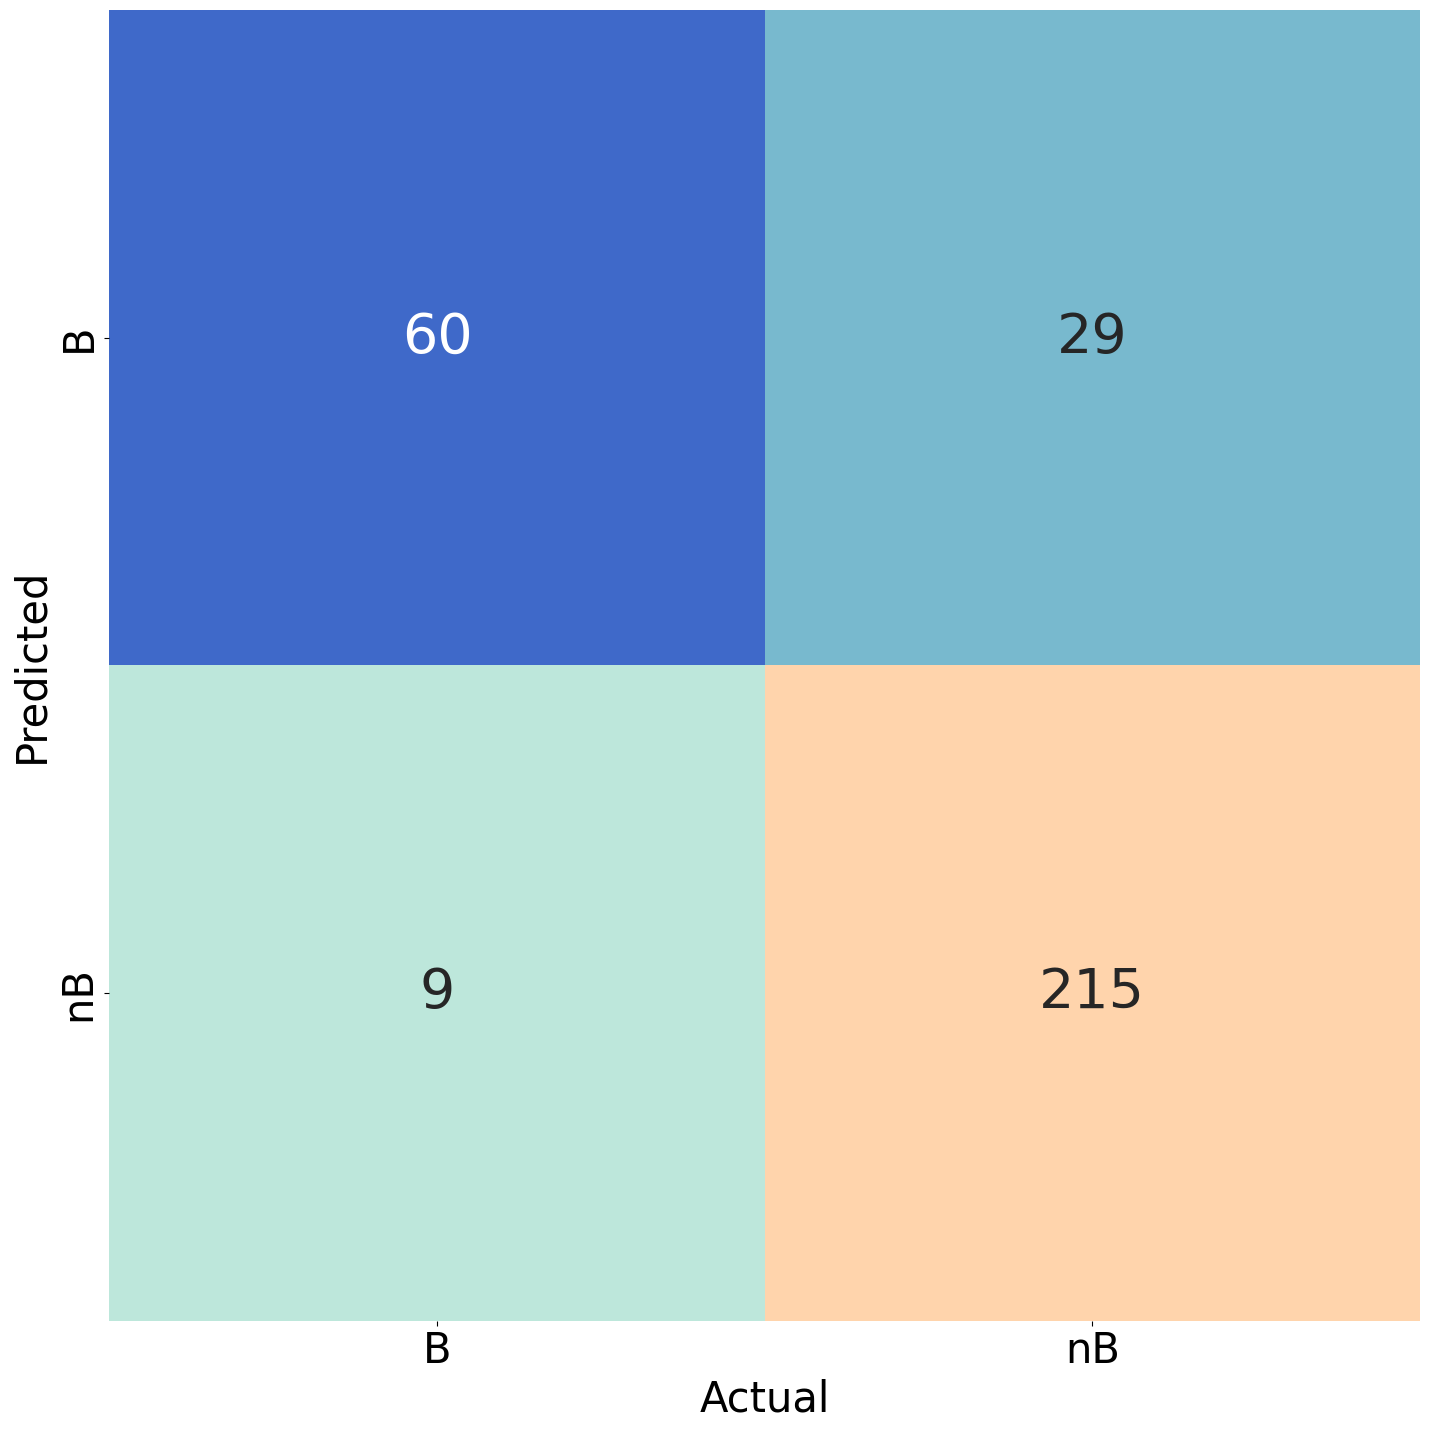

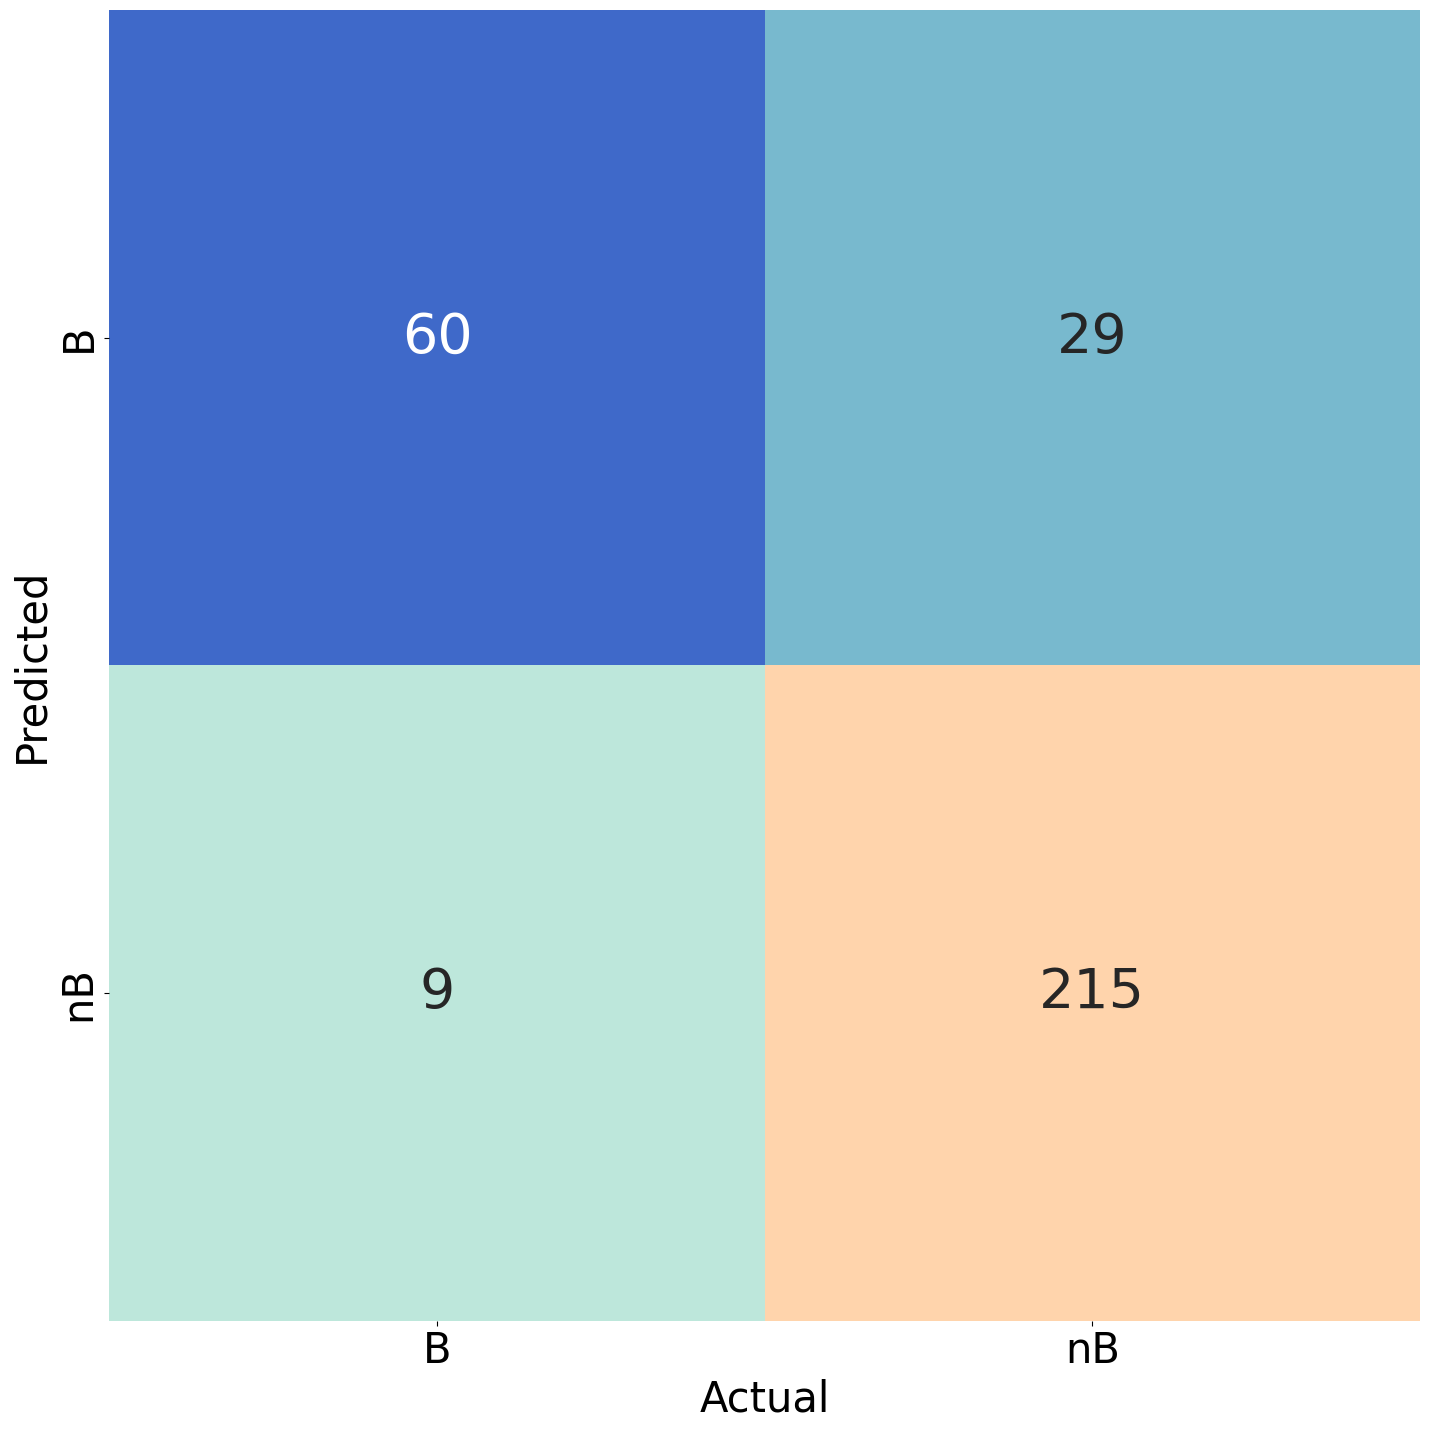

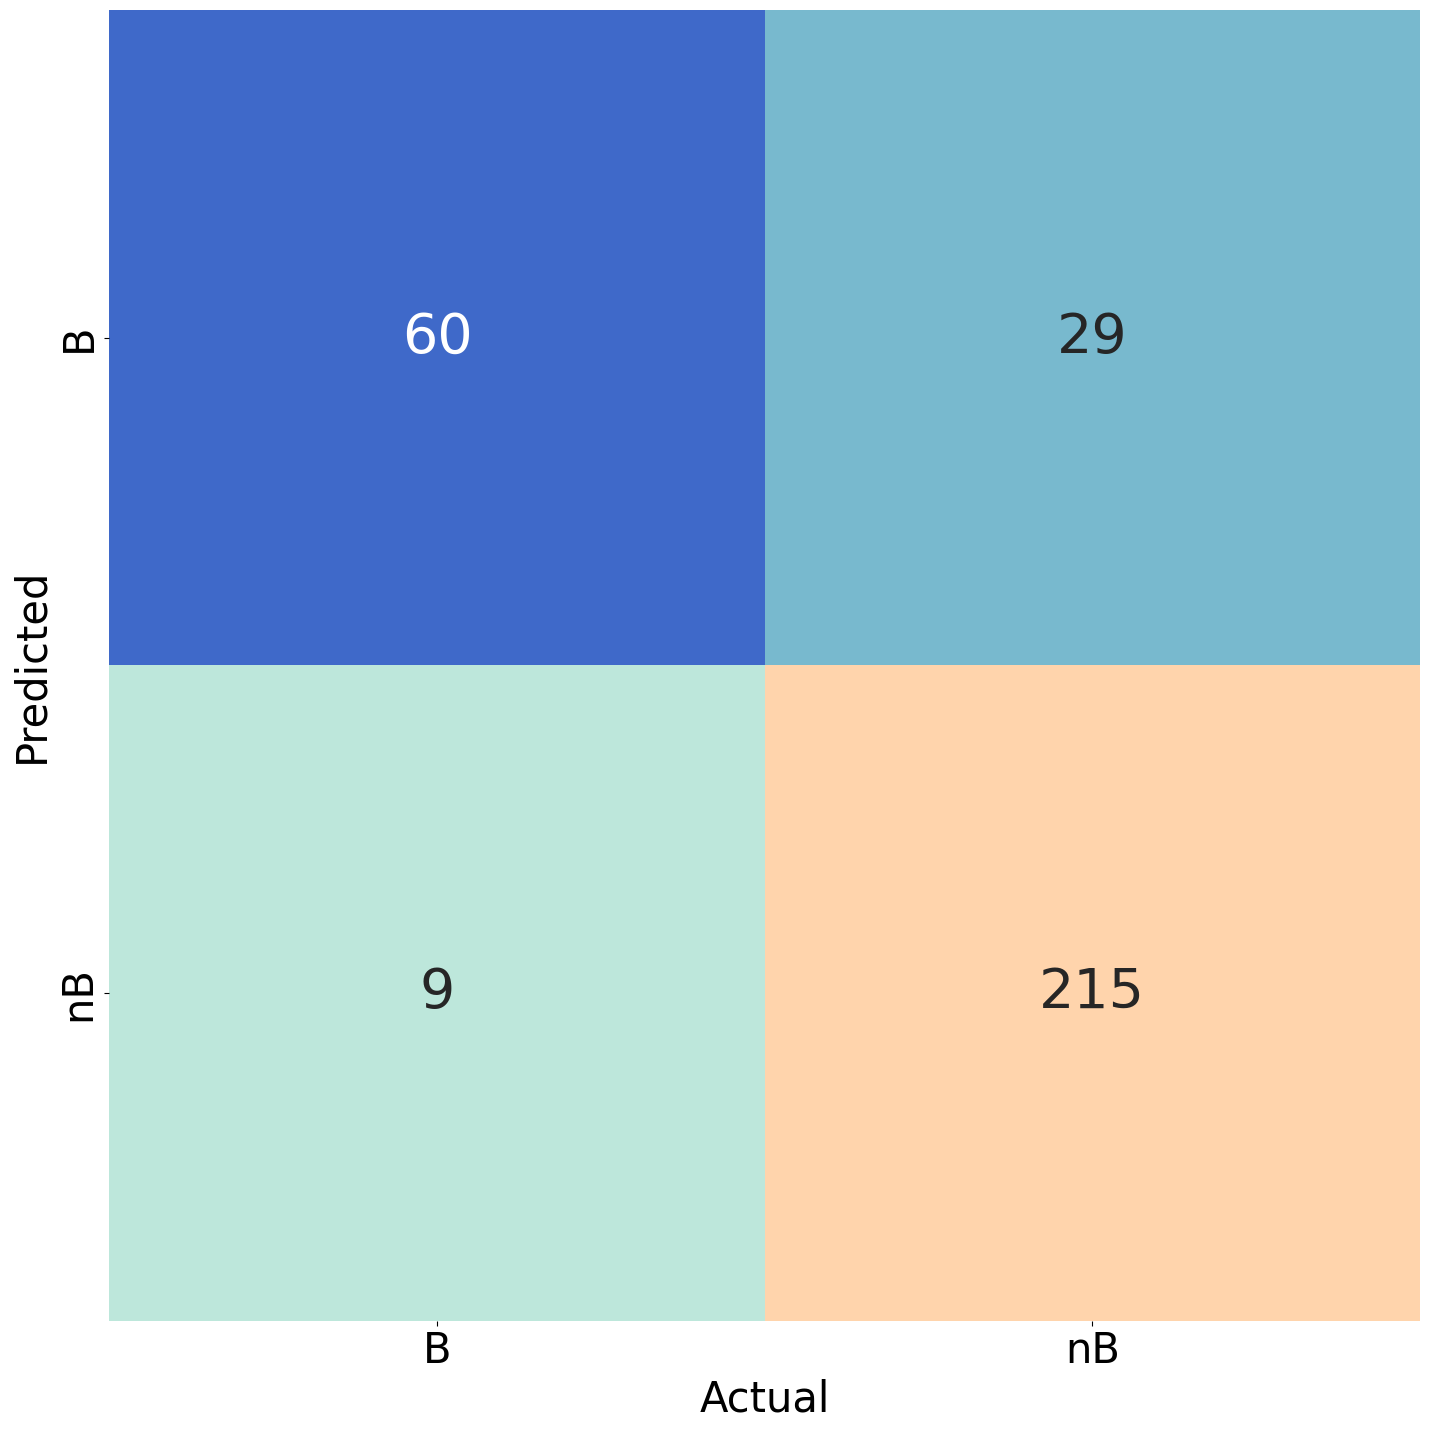

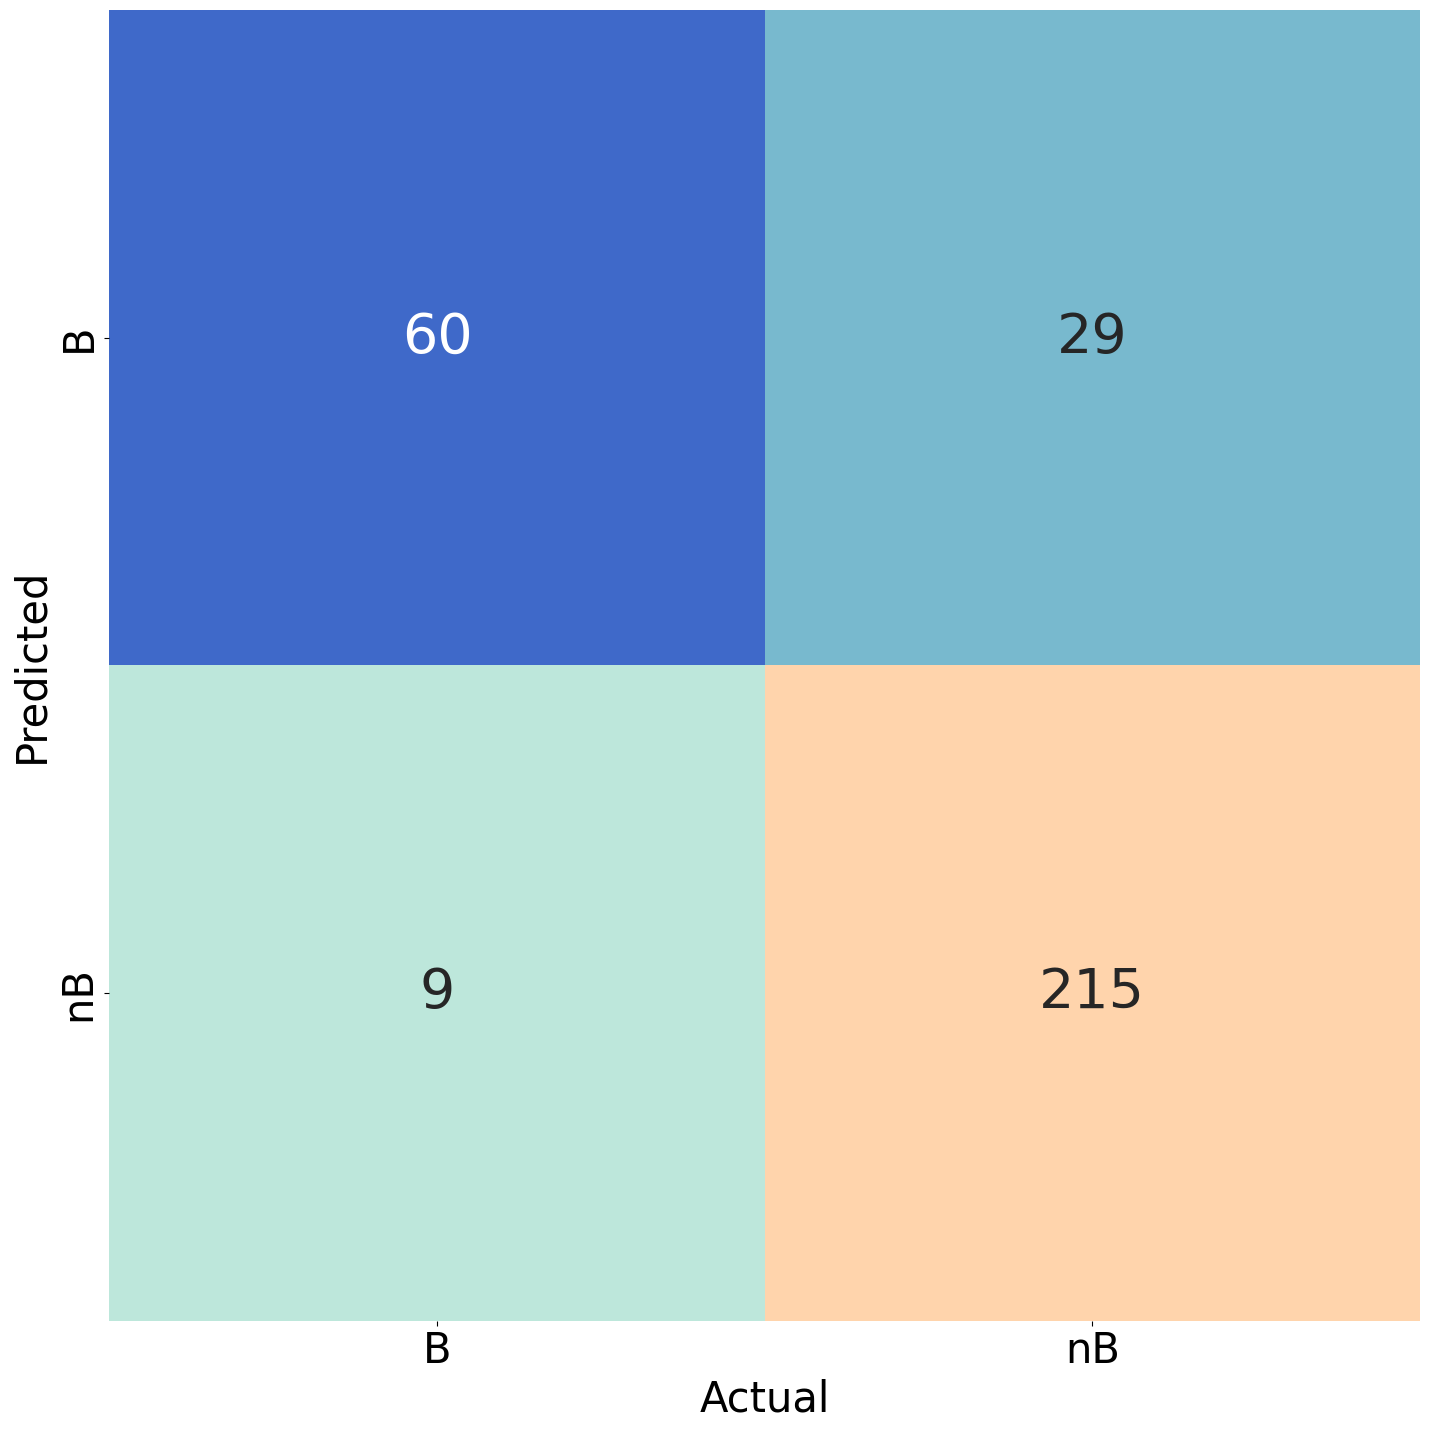

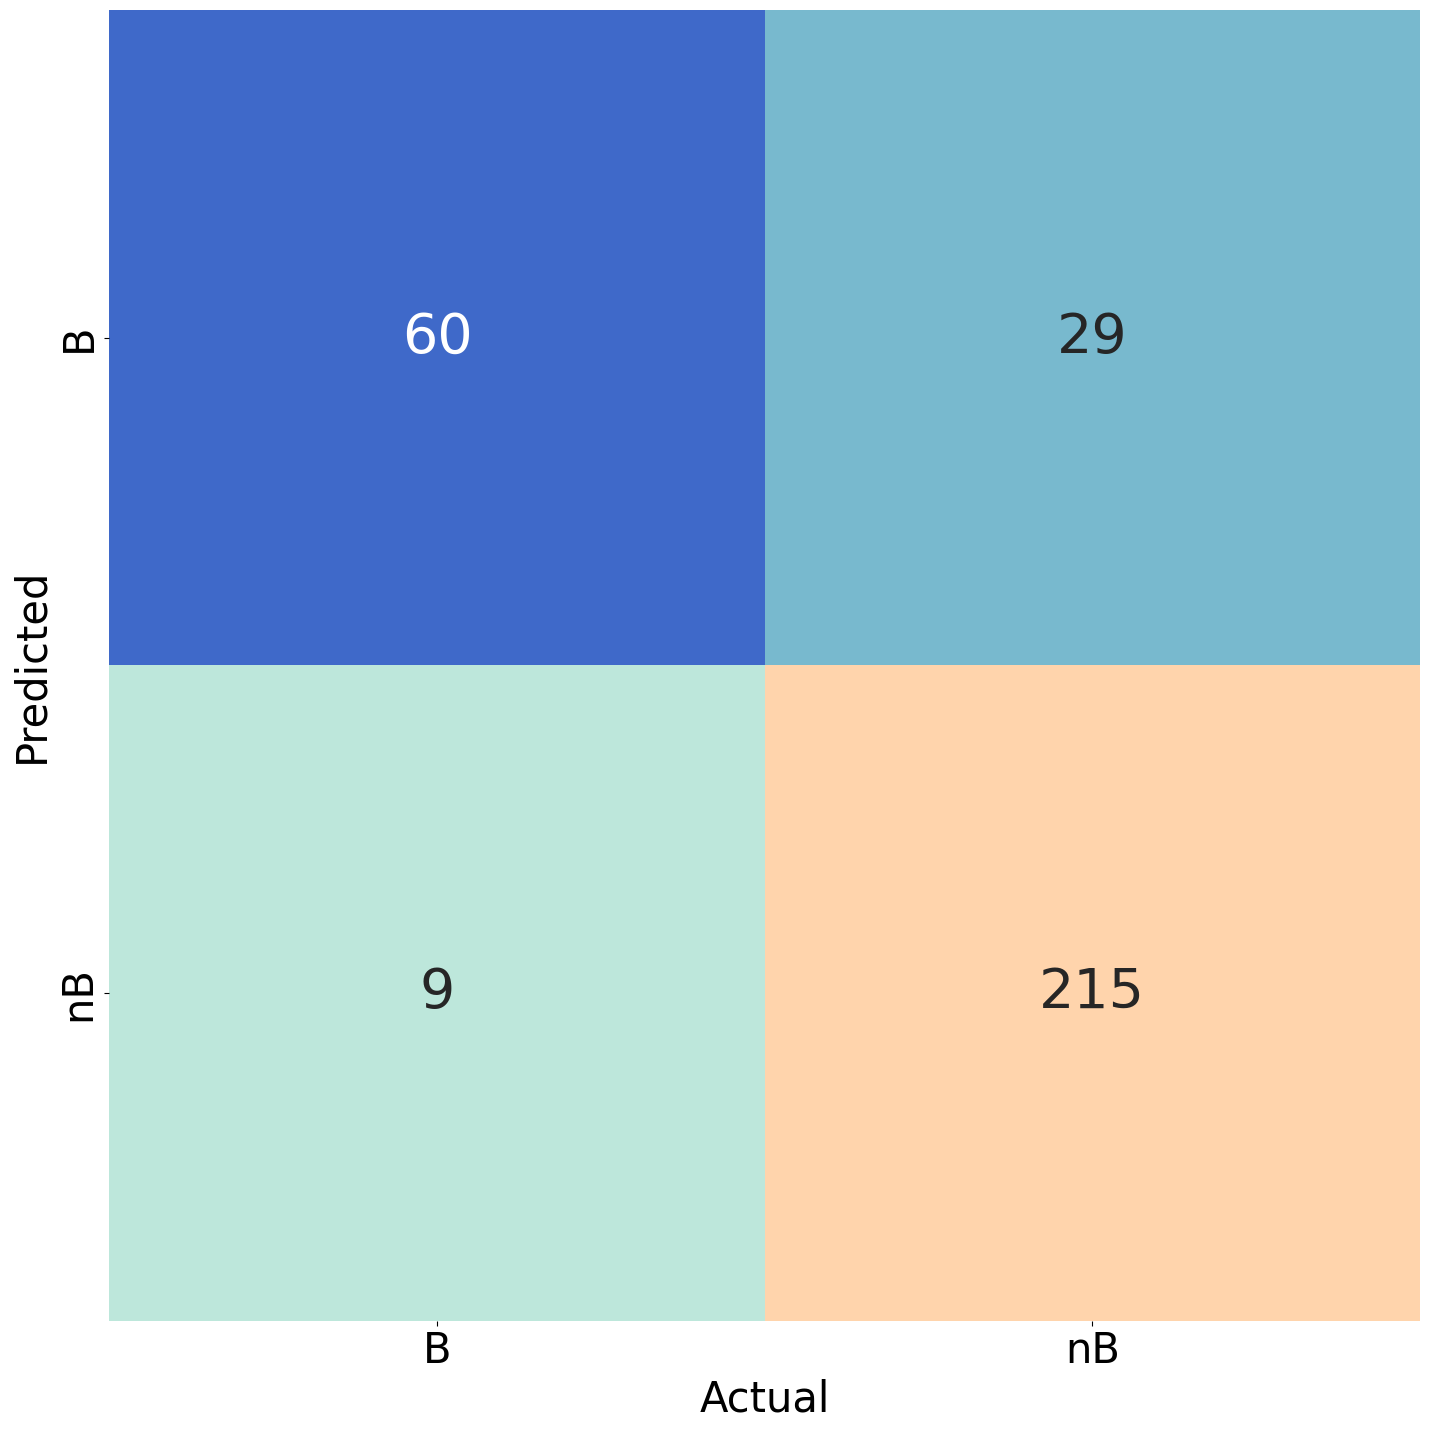

In [41]:
for conf_mat in conf_mats:
    rcParams["font.size"] = 30
    fig, ax = plt.subplots(figsize=(15,15))
    sns.heatmap(
        conf_mat.ravel()[::-1].reshape((2,2)).T,
        annot=True,
        fmt=".3g",
        xticklabels=["B", "nB"],
        yticklabels=["B", "nB"],
        ax = ax,
        cbar = False,
        annot_kws={"fontsize": 40},
        cmap="icefire"
    )
    ax.set(
        ylabel="Predicted",
        xlabel="Actual"
    )
    plt.tight_layout()
    plt.show()

In [42]:
for conf_mat in conf_mats:
    tn, fp, fn, tp = conf_mat.ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp/(tp+fn)
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    print("Specificity:", f"{specificity:.3}"," Sensitivity:", f"{sensitivity:.3}", "Accuracy", f"{accuracy:.3}", "Precision", f"{precision:.3}")


Specificity: 0.881  Sensitivity: 0.87 Accuracy 0.879 Precision 0.674
Specificity: 0.881  Sensitivity: 0.87 Accuracy 0.879 Precision 0.674
Specificity: 0.881  Sensitivity: 0.87 Accuracy 0.879 Precision 0.674
Specificity: 0.881  Sensitivity: 0.87 Accuracy 0.879 Precision 0.674
Specificity: 0.881  Sensitivity: 0.87 Accuracy 0.879 Precision 0.674
